## 초기 설정 및 데이터로딩

In [ ]:
# simple_cnn_har.py
import os, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)
sns.set_context("notebook")

BASE_DIR = "/content/drive/MyDrive/UCI_HAR_Dataset/"

def load_file(path):
    # delim_whitespace=True 대신 sep=r"\s+" 권장 (경고 방지)
    return pd.read_csv(path, header=None, sep=r"\s+").values

def load_group(group, base):
    p = os.path.join(base, group, "Inertial Signals")
    names = [f"total_acc_x_{group}.txt", f"total_acc_y_{group}.txt", f"total_acc_z_{group}.txt",
             f"body_acc_x_{group}.txt",  f"body_acc_y_{group}.txt",  f"body_acc_z_{group}.txt",
             f"body_gyro_x_{group}.txt", f"body_gyro_y_{group}.txt", f"body_gyro_z_{group}.txt"]
    arrays = [load_file(os.path.join(p, n)) for n in names]
    return np.dstack(arrays)

def load_dataset(base=BASE_DIR):
    Xtr = load_group("train", base); ytr = load_file(os.path.join(base, "train", "y_train.txt"))
    Xte = load_group("test",  base); yte = load_file(os.path.join(base, "test",  "y_test.txt"))
    ytr, yte = ytr - 1, yte - 1
    ytr_oh, yte_oh = to_categorical(ytr), to_categorical(yte)
    print(Xtr.shape, ytr.shape, ytr_oh.shape, Xte.shape, yte.shape, yte_oh.shape)
    return Xtr, ytr, ytr_oh, Xte, yte, yte_oh

# ----- Data -----
trainX, trainy_int, trainy, testX, testy_int, testy = load_dataset(BASE_DIR)
X_train, X_val, y_train, y_val = train_test_split(
    trainX, trainy, test_size=0.2, random_state=SEED, stratify=trainy_int
)
nT, nC, nY = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(f"Input: (T={nT}, C={nC}), Classes={nY}")

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
Input: (T=128, C=9), Classes=6


## 모델 정의

In [ ]:
def build_simple_cnn(nT, nC, nY):
    inp = Input((nT, nC))
    x = Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    out = Dense(nY, activation='softmax')(x)
    return Model(inp, out, name="simple_cnn")

model = build_simple_cnn(nT, nC, nY)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cbs = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1, monitor='val_loss')
]
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                 epochs=30, batch_size=32, callbacks=cbs, verbose=1)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6250 - loss: 1.0608 - val_accuracy: 0.9062 - val_loss: 0.3263 - learning_rate: 0.0010
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8947 - loss: 0.3060 - val_accuracy: 0.9375 - val_loss: 0.1902 - learning_rate: 0.0010
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9259 - loss: 0.1947 - val_accuracy: 0.9531 - val_loss: 0.1485 - learning_rate: 0.0010
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9412 - loss: 0.1607 - val_accuracy: 0.9511 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9461 - loss: 0.1413 - val_accuracy: 0.9545 - val_loss: 0.1205 - learning_rate: 0.0010
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9524 - loss: 0.1277 - val_accuracy: 0.9545 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9460 - loss: 0.

## 평가 지표 정의

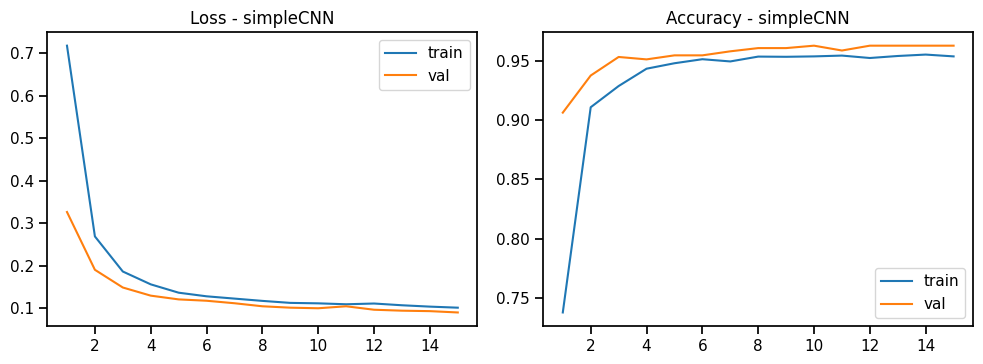

In [ ]:
loss, val_loss = hist.history['loss'], hist.history['val_loss']
acc,  val_acc  = hist.history['accuracy'], hist.history['val_accuracy']
ep = range(1, len(loss)+1)
plt.figure(figsize=(10,3.8))
plt.subplot(1,2,1); plt.plot(ep, loss, label='train'); plt.plot(ep, val_loss, label='val'); plt.title('Loss - simpleCNN'); plt.legend()
plt.subplot(1,2,2); plt.plot(ep, acc,  label='train'); plt.plot(ep, val_acc,  label='val'); plt.title('Accuracy - simpleCNN'); plt.legend()
plt.tight_layout(); plt.show()

## 학습 및 검증


== simpleCNN Test Accuracy: 0.9057
              precision    recall  f1-score   support

           0     0.9938    0.9738    0.9837       496
           1     0.8840    0.9384    0.9104       471
           2     0.9143    0.9905    0.9509       420
           3     0.8108    0.7678    0.7887       491
           4     0.8305    0.8289    0.8297       532
           5     1.0000    0.9497    0.9742       537

    accuracy                         0.9057      2947
   macro avg     0.9056    0.9082    0.9063      2947
weighted avg     0.9061    0.9057    0.9053      2947



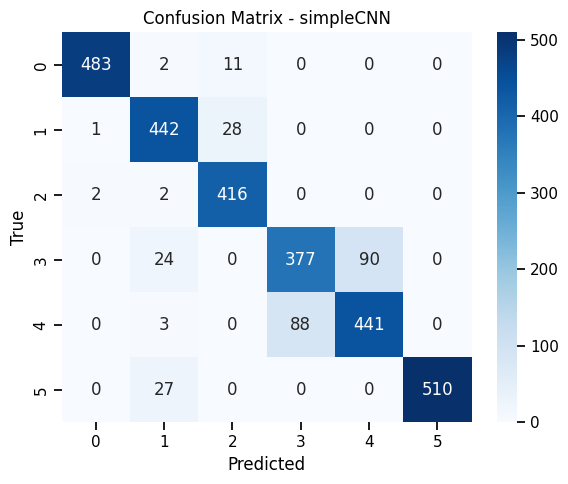

In [ ]:
prob = model.predict(testX, verbose=0)
pred = prob.argmax(axis=-1)
acc_test = accuracy_score(testy_int, pred)
print(f"\n== simpleCNN Test Accuracy: {acc_test:.4f}")
print(classification_report(testy_int, pred, digits=4))
cm = confusion_matrix(testy_int, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - simpleCNN'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()
